In [1]:
!pip install stable-baselines3[extra]
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install websockets>=15.0.0 --quiet
!pip install transformers --quiet
!pip install polygon-api-client --quiet

zsh:1: no matches found: stable-baselines3[extra]
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-req-build-i6g8xlns
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-req-build-i6g8xlns
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit f4283de63ca73c915321c5555fa3751698a61eec
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-install-15p8a8b6/elegantrl_ee619c621e97468d889d0ab7e27059f4
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-install-15p8

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import pkg_resources
import yfinance as yf
from datetime import timedelta, date
from polygon import RESTClient
from transformers import BertTokenizer, BertForSequenceClassification
import torch as th
import torch.nn as nn

import stable_baselines3
import finrl

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.config import INDICATORS

%matplotlib inline
plt.close('all')

print(f"SB3 Version:    {stable_baselines3.__version__}")
print(f"FinRL Version:  {pkg_resources.get_distribution('finrl').version}")
print(f"CUDA Available: {th.cuda.is_available()}")

# ── Mac GPU (Metal / MPS) detection ──────────────────────────────────────────
if th.backends.mps.is_available():
    DEVICE = th.device('mps')
    print("MPS (Apple Metal GPU) available — using GPU ✓")
elif th.cuda.is_available():
    DEVICE = th.device('cuda')
    print(f"CUDA GPU available — using {th.cuda.get_device_name(0)} ✓")
else:
    DEVICE = th.device('cpu')
    print("No GPU found — falling back to CPU")

print(f"Active device: {DEVICE}")

/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/ipykernel_74015/2172458160.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SB3 Version:    2.8.0a2
FinRL Version:  0.3.8
CUDA Available: False
MPS (Apple Metal GPU) available — using GPU ✓
Active device: mps


In [ ]:
# ============================================================
# CELL 2b — FinBERT + Polygon Sentiment Utilities
# ============================================================
import os
import pickle
import time

POLYGON_API_KEY  = os.environ.get('POLYGON_API_KEY', 'YOUR_POLYGON_API_KEY')
polygon_client   = RESTClient(api_key=POLYGON_API_KEY)
SENTIMENT_DEVICE = 'cpu'

print("Loading FinBERT...")
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
finbert   = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')
finbert   = finbert.to(SENTIMENT_DEVICE)
finbert.eval()
print("FinBERT loaded ✓")
print("Polygon client initialised ✅")


def score_headlines(headlines: list) -> float:
    if not headlines:
        return 0.0
    scores = []
    for text in headlines:
        inputs = tokenizer(
            text, return_tensors='pt',
            truncation=True, max_length=128, padding=True
        ).to(SENTIMENT_DEVICE)
        with th.no_grad():
            logits = finbert(**inputs).logits
            probs  = th.softmax(logits, dim=1).squeeze()
        scores.append(probs[0].item() - probs[1].item())
    return float(np.mean(scores))


def fetch_sentiment_polygon(ticker: str,
                             start_date: str,
                             end_date: str) -> pd.Series:
    """
    Fetch headlines from Polygon.io and score with FinBERT.
    Full historical coverage — no 30-day restriction.
    """
    daily_headlines = {}
    try:
        for article in polygon_client.list_ticker_news(
            ticker,
            published_utc_gte=start_date,
            published_utc_lte=end_date,
            limit=1000,
            sort='published_utc',
            order='asc'
        ):
            try:
                pub_ts   = pd.Timestamp(article.published_utc)
                date_str = pub_ts.strftime('%Y-%m-%d')
                title    = getattr(article, 'title', '') or ''
                if title:
                    daily_headlines.setdefault(date_str, []).append(title)
            except Exception:
                continue
    except Exception as e:
        print(f"  Warning: Polygon error for {ticker}: {e}")

    return pd.Series(
        {d: score_headlines(h) for d, h in daily_headlines.items()},
        name=ticker
    )


def build_sentiment_df(tickers: list, start_date: str,
                        end_date: str) -> pd.DataFrame:
    """
    Build sentiment DataFrame for all tickers.
    Rate limited to 5 calls/min on free tier — 12s sleep between tickers.
    First run ~30-45 mins, instant from cache after.
    """
    print(f"Fetching Polygon sentiment for {len(tickers)} tickers "
          f"({start_date} → {end_date})...")
    series_list = []
    for i, ticker in enumerate(tickers):
        print(f"  [{i+1}/{len(tickers)}] {ticker}    ", end='\r')
        s = fetch_sentiment_polygon(ticker, start_date, end_date)
        series_list.append(s)
        time.sleep(12)

    df_sent = pd.DataFrame(series_list).T
    df_sent.index.name = 'date'
    df_sent = df_sent.sort_index().ffill().fillna(0.0)
    print(f"\nDone. Shape: {df_sent.shape}")
    print(f"Non-zero entries: {(df_sent != 0).sum().sum():,}")
    return df_sent


def build_sentiment_df_cached(tickers: list, start_date: str,
                               end_date: str,
                               cache_file: str = 'sentiment_cache.pkl') -> pd.DataFrame:
    """Historical data cached permanently. Live data refreshes daily."""
    today_str     = date.today().strftime('%Y-%m-%d')
    is_historical = end_date < today_str

    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached = pickle.load(f)
        if is_historical or cached.get('fetch_date') == today_str:
            print(f"✅ Loaded from cache: {cache_file}")
            return cached['df']
        print(f"Cache stale — fetching fresh from Polygon...")
    else:
        print(f"No cache found — fetching from Polygon...")

    df_sent = build_sentiment_df(tickers, start_date, end_date)
    with open(cache_file, 'wb') as f:
        pickle.dump({
            'fetch_date': today_str,
            'start_date': start_date,
            'end_date':   end_date,
            'df':         df_sent
        }, f)
    print(f"✅ Cached to {cache_file}")
    return df_sent

Loading FinBERT...


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 2787.37it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


FinBERT loaded ✓
Polygon client initialised ✅


In [4]:
# ============================================================
# CELL 3 — Download Data
# ============================================================
TICKERS = [
    'NVDA', 'AAPL', 'GOOGL', 'GOOG', 'MSFT', 'AMZN', 'META', 'AVGO', 'TSLA',
    'WMT', 'LLY', 'JPM', 'XOM', 'V', 'JNJ', 'MU','MA', 'COST', 'ORCL',
    'ABBV',  'BAC', 'HD', 'PG', 'CVX', 'GE', 'CAT',  'KO', 'NFLX', 'AMD','CSCO'
]
NUM_STOCKS = len(TICKERS)  # 30 — use this constant everywhere, no magic numbers

# Download training data
df_raw_train = YahooDownloader(
    start_date='2020-01-01',
    end_date='2024-01-01',
    ticker_list=TICKERS
).fetch_data()

# Download test data (held-out period)
df_raw_test = YahooDownloader(
    start_date='2024-01-01',
    end_date='2025-01-01',
    ticker_list=TICKERS
).fetch_data()

# Add Technical Indicators
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_vix=False,
    use_turbulence=False
)

df_train = fe.preprocess_data(df_raw_train)
df_test  = fe.preprocess_data(df_raw_test)

print(f"Train shape: {df_train.shape}")
print(f"Test shape:  {df_test.shape}")

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (30180, 8)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (7560, 8)
Successfully added technical indicators
Successfully added technical indicators
Train shape: (30180, 16)
Test shape:  (7560, 16)


In [5]:
# ============================================================
# CELL 2c — Fetch Sentiment Scores via Polygon
# ============================================================
# Full 2020-2024 coverage — no 30-day limit.
# First run: ~30-45 mins. Subsequent runs: instant.

TRAIN_START = '2020-01-01'
TRAIN_END   = '2024-01-01'
TEST_START  = '2024-01-01'
TEST_END    = '2025-01-01'

print("Fetching training sentiment via Polygon (2020-2024)...")
print("First run takes ~30-45 mins — cached permanently after that.")
df_sent_train = build_sentiment_df_cached(
    TICKERS, TRAIN_START, TRAIN_END,
    cache_file='sentiment_train_polygon_yfinance.pkl'
)

print("\nFetching test sentiment via Polygon (2024-2025)...")
df_sent_test = build_sentiment_df_cached(
    TICKERS, TEST_START, TEST_END,
    cache_file='sentiment_test_polygon_yfinance.pkl'
)

total         = df_sent_train.size
nonzero_train = (df_sent_train != 0).sum().sum()
nonzero_test  = (df_sent_test  != 0).sum().sum()
print(f"\nSentiment coverage:")
print(f"  Train non-zero: {nonzero_train:,} / {total:,} "
      f"({nonzero_train/total*100:.1f}%)")
print(f"  Test  non-zero: {nonzero_test:,}")
print(df_sent_train.tail())

Fetching training sentiment via Polygon (2020-2024)...
First run takes ~30-45 mins — cached permanently after that.
No cache found — fetching from Polygon...
Fetching Polygon sentiment for 30 tickers (2020-01-01 → 2024-01-01)...
  [30/30] CSCO    
Done. Shape: (1183, 30)
Non-zero entries: 34,047
✅ Cached to sentiment_train_polygon_yfinance.pkl

Fetching test sentiment via Polygon (2024-2025)...
No cache found — fetching from Polygon...
Fetching Polygon sentiment for 30 tickers (2024-01-01 → 2025-01-01)...
  [30/30] CSCO    
Done. Shape: (367, 30)
Non-zero entries: 11,005
✅ Cached to sentiment_test_polygon_yfinance.pkl

Sentiment coverage:
  Train non-zero: 34,047 / 35,490 (95.9%)
  Test  non-zero: 11,005
                NVDA      AAPL     GOOGL      GOOG      MSFT      AMZN  \
date                                                                     
2023-12-28  0.244513  0.122119  0.120230  0.152342  0.095102  0.151735   
2023-12-29  0.138105 -0.067385  0.120770 -0.048561  0.163821  0.

In [6]:

# ============================================================
# CELL 4 — Clean, Validate & Merge Sentiment (Corrected)
# ============================================================

# Define here so both Cell 4 and Cell 5 can reference it
INDICATORS_WITH_SENT = INDICATORS + ['sentiment']
INDICATORS_COUNT     = len(INDICATORS_WITH_SENT)

def prepare_df(df, df_sentiment, n_stocks=NUM_STOCKS):
    df = df.rename(columns={'datadate': 'date'})
    df = df.sort_values(['date', 'tic']).reset_index(drop=True)

    ticker_counts = df.groupby('date')['tic'].nunique()
    incomplete    = ticker_counts[ticker_counts != n_stocks].index
    if len(incomplete) > 0:
        print(f"Dropping {len(incomplete)} incomplete date(s)")
        df = df[~df['date'].isin(incomplete)].reset_index(drop=True)

    df_sent_long = df_sentiment.reset_index().melt(
        id_vars='date',
        var_name='tic',
        value_name='sentiment'
    )
    df_sent_long['date'] = df_sent_long['date'].astype(str).str[:10]
    df['date_str']       = df['date'].astype(str).str[:10]

    df = df.merge(
        df_sent_long,
        left_on=['date_str', 'tic'],
        right_on=['date', 'tic'],
        how='left',
        suffixes=('', '_sent')
    ).drop(columns=['date_sent', 'date_str'], errors='ignore')

    df['sentiment'] = df['sentiment'].fillna(0.0)

    non_zero = (df['sentiment'] != 0).sum()
    print(f"Sentiment merged — non-zero rows: {non_zero} / {len(df)}")

    assert 'sentiment' in df.columns, "sentiment column missing!"

    df.index = df['date'].factorize()[0]
    return df

df_train = prepare_df(df_train, df_sent_train)
df_test  = prepare_df(df_test,  df_sent_test)

# Sanity check — now INDICATORS_WITH_SENT is defined above so this works
print(f"\nAll required indicator columns present in df_train:")
for ind in INDICATORS_WITH_SENT:
    present = ind in df_train.columns
    print(f"  {ind}: {'✅' if present else '❌ MISSING'}")

print(f"\nTrain ready — {df_train['date'].nunique()} trading days")
print(f"Test  ready — {df_test['date'].nunique()} trading days")

# ============================================================
# CELL 5 — Define Model & Train (Sentiment-Aware, Corrected)
# ============================================================
#INDICATORS_WITH_SENT = INDICATORS + ['sentiment']
#INDICATORS_COUNT     = len(INDICATORS_WITH_SENT)
INDICATORS_START_IDX = 1 + NUM_STOCKS + NUM_STOCKS
STATE_SPACE          = INDICATORS_START_IDX + (NUM_STOCKS * INDICATORS_COUNT)

# Sanity check — make sure state space matches what the env will actually see
expected_cols = 1 + NUM_STOCKS + NUM_STOCKS + (NUM_STOCKS * INDICATORS_COUNT)
print(f"Expected state space: {STATE_SPACE}")
print(f"  = 1 cash + {NUM_STOCKS} prices + {NUM_STOCKS} shares "
      f"+ {NUM_STOCKS} stocks x {INDICATORS_COUNT} indicators")
assert STATE_SPACE == expected_cols, \
    f"State space mismatch: {STATE_SPACE} vs {expected_cols}"
print("State space verified ✅")

class VGG_FinRL_Extractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=512,
                 n_stocks=NUM_STOCKS, n_ind=INDICATORS_COUNT):
        super().__init__(observation_space, features_dim)
        self.n_stocks = n_stocks
        self.n_ind    = n_ind

        self.input_norm = nn.BatchNorm2d(1)

        self.vgg = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
        )

        with th.no_grad():
            sample    = th.zeros(1, 1, n_stocks, n_ind)
            _norm_cpu = nn.BatchNorm2d(1)
            _vgg_cpu  = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32), nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64), nn.ReLU(),
            )
            sample    = _norm_cpu(sample)
            n_flatten = _vgg_cpu(sample).numel()

        self.fc = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )

    def forward(self, observations):
        img_data = observations[:, INDICATORS_START_IDX:]
        img_data = img_data.view(-1, 1, self.n_stocks, self.n_ind)
        img_data = self.input_norm(img_data)
        x = self.vgg(img_data)
        x = th.flatten(x, start_dim=1)
        return self.fc(x)

policy_kwargs = dict(
    features_extractor_class=VGG_FinRL_Extractor,
    features_extractor_kwargs=dict(
        features_dim=512,
        n_stocks=NUM_STOCKS,
        n_ind=INDICATORS_COUNT
    ),
)

def make_env(df):
    return StockTradingEnv(
        df=df,
        num_stock_shares=[0] * NUM_STOCKS,
        reward_scaling=1e-4,
        stock_dim=NUM_STOCKS,
        hmax=100,
        initial_amount=1_000_000,
        buy_cost_pct=[0.001]  * NUM_STOCKS,
        sell_cost_pct=[0.001] * NUM_STOCKS,
        state_space=STATE_SPACE,
        tech_indicator_list=INDICATORS_WITH_SENT,  # sentiment included here
        action_space=NUM_STOCKS
    )

e_train_gym = make_env(df_train)
e_test_gym  = make_env(df_test)

env_train, _ = e_train_gym.get_sb_env()

model_params = {
    "n_steps":       2048,
    "ent_coef":      0.01,
    "learning_rate": 0.0001,
    "batch_size":    64,
    "device":        DEVICE,
}

agent     = DRLAgent(env=env_train)
model_vgg = agent.get_model(
    "ppo",
    policy_kwargs=policy_kwargs,
    model_kwargs=model_params,
    verbose=1
)

print("\nStarting Sentiment-Aware VGG Training...")
trained_vgg = agent.train_model(
    model=model_vgg,
    tb_log_name='vgg_ppo_sentiment_run',
    total_timesteps=500_000
)
# ============================================================
# CELL 6 — Sanity Check Training Behaviour
# ============================================================
shares_start = 1 + NUM_STOCKS   # skip Cash + Prices
shares_end   = shares_start + NUM_STOCKS

final_shares = np.array(e_train_gym.state_memory)[-1][shares_start:shares_end]
print(f"Total shares held across all stocks: {np.sum(final_shares)}")

actions = np.array(e_train_gym.actions_memory)
print(f"Average absolute action strength: {np.mean(np.abs(actions)):.6f}")

def compute_metrics(df_account_value: pd.DataFrame,
                    initial_capital: float = 1_000_000) -> dict:
    """
    Compute key trading performance metrics from account value history.

    Metrics:
      - Total Return:       overall % gain/loss
      - Sharpe Ratio:       risk-adjusted return (annualised)
      - Max Drawdown:       largest peak-to-trough decline (%)
      - Win Rate:           % of days with positive return
      - Avg Daily Return:   mean daily % return
      - Volatility:         annualised std of daily returns
      - Calmar Ratio:       total return / max drawdown
    """
    values  = pd.Series(df_account_value['account_value'].values,
                        index=pd.to_datetime(df_account_value['date'].values))

    # Daily returns
    daily_returns = values.pct_change().dropna()

    # Total return
    total_return = (values.iloc[-1] - initial_capital) / initial_capital * 100

    # Sharpe ratio (annualised, assuming 252 trading days)
    sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) \
             if daily_returns.std() > 0 else 0.0

    # Maximum drawdown
    rolling_max  = values.cummax()
    drawdown     = (values - rolling_max) / rolling_max * 100
    max_drawdown = drawdown.min()   # most negative value = worst drawdown

    # Win rate — % of days with positive return
    win_rate = (daily_returns > 0).sum() / len(daily_returns) * 100

    # Average daily return
    avg_daily_return = daily_returns.mean() * 100

    # Annualised volatility
    volatility = daily_returns.std() * np.sqrt(252) * 100

    # Calmar ratio (total return / abs max drawdown)
    calmar = abs(total_return / max_drawdown) if max_drawdown != 0 else 0.0

    return {
        'Total Return (%)':     round(total_return, 2),
        'Sharpe Ratio':         round(sharpe, 3),
        'Max Drawdown (%)':     round(max_drawdown, 2),
        'Win Rate (%)':         round(win_rate, 2),
        'Avg Daily Return (%)': round(avg_daily_return, 4),
        'Volatility (%)':       round(volatility, 2),
        'Calmar Ratio':         round(calmar, 3),
    }


# Compute and print metrics for training environment
# We need to run a quick prediction pass on the training env
# to get a clean account value history
df_train_account, _ = DRLAgent.DRL_prediction(
    model=trained_vgg,
    environment=e_train_gym
)


Sentiment merged — non-zero rows: 24242 / 30180
Sentiment merged — non-zero rows: 7558 / 7560

All required indicator columns present in df_train:
  macd: ✅
  boll_ub: ✅
  boll_lb: ✅
  rsi_30: ✅
  cci_30: ✅
  dx_30: ✅
  close_30_sma: ✅
  close_60_sma: ✅
  sentiment: ✅

Train ready — 1006 trading days
Test  ready — 252 trading days
Expected state space: 331
  = 1 cash + 30 prices + 30 shares + 30 stocks x 9 indicators
State space verified ✅
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0001, 'batch_size': 64, 'device': device(type='mps')}
Using mps device


/opt/miniconda3/lib/python3.13/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(



Starting Sentiment-Aware VGG Training...
-----------------------------------
| time/              |            |
|    fps             | 196        |
|    iterations      | 1          |
|    time_elapsed    | 10         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -1.965114  |
|    reward_max      | 8.7360115  |
|    reward_mean     | 0.07313529 |
|    reward_min      | -9.565431  |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 2           |
|    time_elapsed         | 27          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009832602 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | 0.00228     |
|    learning_rate    

Computing training metrics...


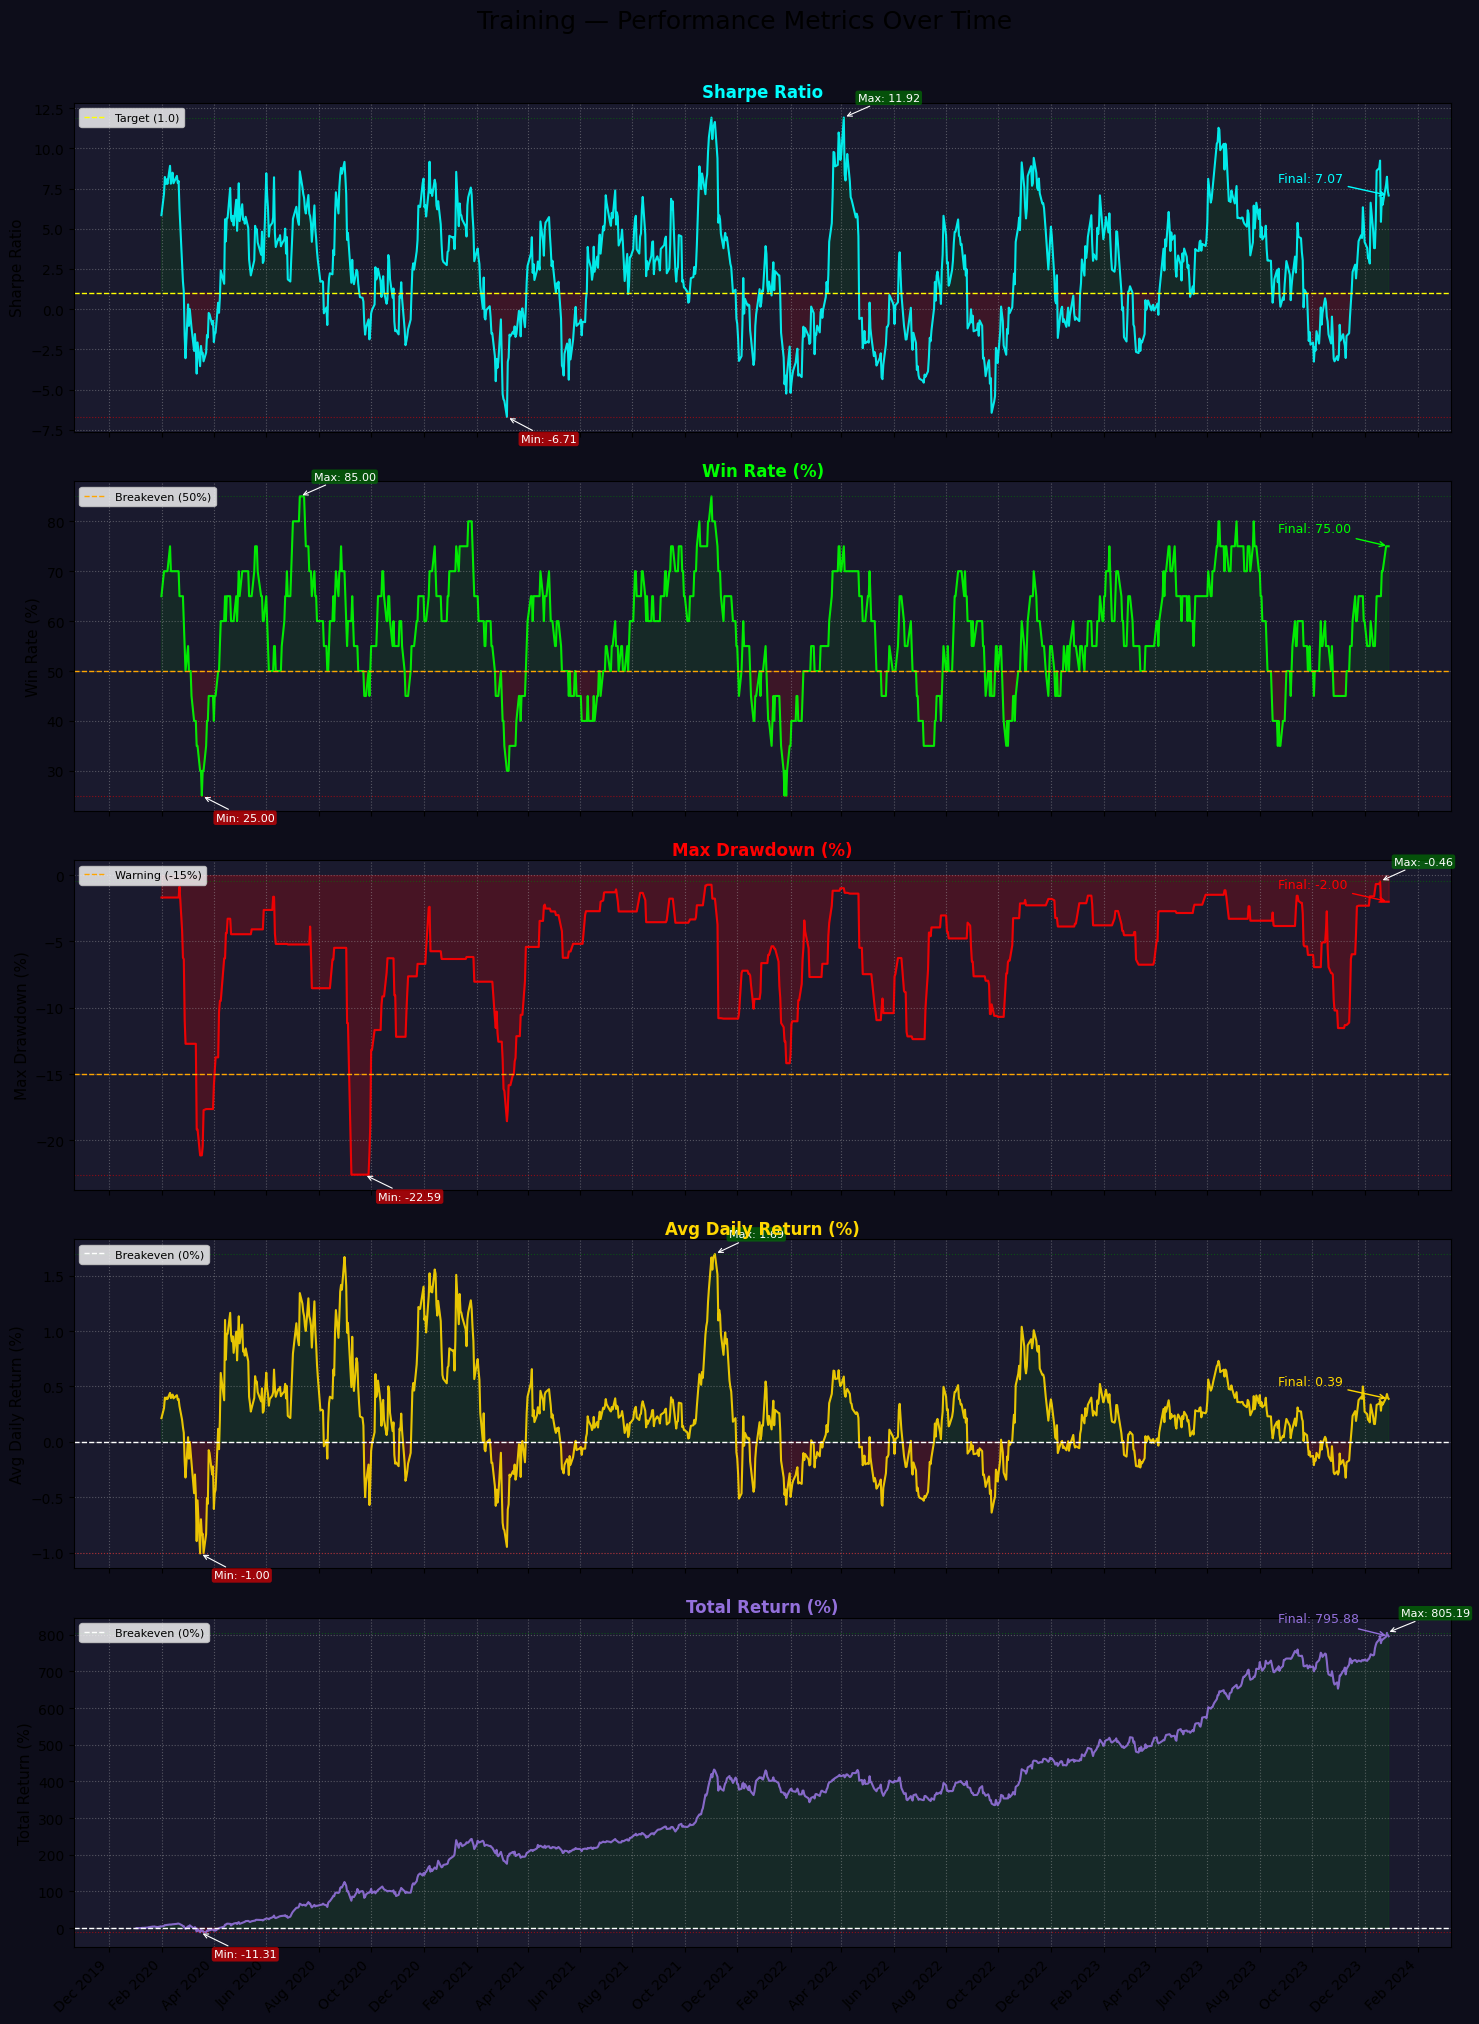


  TRAINING — METRIC SUMMARY
  Metric                         Avg      Max      Min    Final
  ---------------------------------------------------------
  Sharpe Ratio                  2.40    11.92    -6.71     7.07
  Win Rate (%)                 57.82    85.00    25.00    75.00
  Max Drawdown (%)             -6.01    -0.46   -22.59    -2.00
  Avg Daily Return (%)          0.24     1.69    -1.00     0.39
  Total Return (%)            795.88   805.19   -11.31   795.88


In [11]:
# ============================================================
# CELL 6b — Plot Metrics Over Time
# ============================================================

def compute_rolling_metrics(df_account_value: pd.DataFrame,
                             initial_capital: float = 1_000_000,
                             window: int = 20) -> pd.DataFrame:
    """
    Compute rolling metrics over time.
    window: rolling window in trading days (default 20 = 1 month)
    """
    values = pd.Series(
        df_account_value['account_value'].values,
        index=pd.to_datetime(df_account_value['date'].values)
    )

    daily_returns = values.pct_change().dropna()

    rolling_sharpe = (
        daily_returns.rolling(window).mean() /
        daily_returns.rolling(window).std()
    ) * np.sqrt(252)

    rolling_win_rate = (
        daily_returns.rolling(window)
        .apply(lambda x: (x > 0).sum() / len(x) * 100)
    )

    def rolling_max_drawdown(returns):
        cum  = (1 + returns).cumprod()
        peak = cum.cummax()
        dd   = (cum - peak) / peak * 100
        return dd.min()

    rolling_max_dd     = daily_returns.rolling(window).apply(rolling_max_drawdown)
    rolling_avg_return = daily_returns.rolling(window).mean() * 100
    total_return       = (values - initial_capital) / initial_capital * 100

    return pd.DataFrame({
        'Sharpe Ratio':         rolling_sharpe,
        'Win Rate (%)':         rolling_win_rate,
        'Max Drawdown (%)':     rolling_max_dd,
        'Avg Daily Return (%)': rolling_avg_return,
        'Total Return (%)':     total_return,
    })


def plot_metrics(metrics_df: pd.DataFrame, title_prefix: str = 'Training'):
    """
    Plot all five metrics with subplot titles, max/min annotations,
    and a summary table showing avg, max, min and final values.
    """
    fig, axes = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
    fig.suptitle(f'{title_prefix} — Performance Metrics Over Time',
                 fontsize=18, y=1.01)

    plot_config = [
        {'col': 'Sharpe Ratio',         'color': 'cyan',
         'ylabel': 'Sharpe Ratio',
         'hline': 1.0,  'hline_label': 'Target (1.0)',
         'hline_color': 'yellow'},
        {'col': 'Win Rate (%)',          'color': 'lime',
         'ylabel': 'Win Rate (%)',
         'hline': 50.0, 'hline_label': 'Breakeven (50%)',
         'hline_color': 'orange'},
        {'col': 'Max Drawdown (%)',      'color': 'red',
         'ylabel': 'Max Drawdown (%)',
         'hline': -15.0, 'hline_label': 'Warning (-15%)',
         'hline_color': 'orange'},
        {'col': 'Avg Daily Return (%)',  'color': 'gold',
         'ylabel': 'Avg Daily Return (%)',
         'hline': 0.0,  'hline_label': 'Breakeven (0%)',
         'hline_color': 'white'},
        {'col': 'Total Return (%)',      'color': 'mediumpurple',
         'ylabel': 'Total Return (%)',
         'hline': 0.0,  'hline_label': 'Breakeven (0%)',
         'hline_color': 'white'},
    ]

    for ax, cfg in zip(axes, plot_config):
        series = metrics_df[cfg['col']].dropna()

        ax.plot(series.index, series.values,
                color=cfg['color'], linewidth=1.5, alpha=0.9)
        ax.axhline(cfg['hline'], color=cfg['hline_color'],
                   linestyle='--', linewidth=1, label=cfg['hline_label'])

        if cfg['col'] == 'Max Drawdown (%)':
            ax.fill_between(series.index, series.values, 0,
                            alpha=0.2, color='red')
        else:
            ax.fill_between(series.index, series.values, cfg['hline'],
                            where=series.values >= cfg['hline'],
                            alpha=0.15, color='green')
            ax.fill_between(series.index, series.values, cfg['hline'],
                            where=series.values < cfg['hline'],
                            alpha=0.15, color='red')

        # Subplot title in matching colour
        ax.set_title(cfg['col'], fontsize=12, color=cfg['color'],
                     fontweight='bold', pad=4)
        ax.set_ylabel(cfg['ylabel'], fontsize=11)
        ax.grid(True, linestyle=':', alpha=0.4)
        ax.set_facecolor('#1a1a2e')

        if len(series) > 0:
            final_val = series.iloc[-1]
            max_val   = series.max()
            min_val   = series.min()
            max_date  = series.idxmax()
            min_date  = series.idxmin()

            # Final value annotation
            ax.annotate(
                f'Final: {final_val:.2f}',
                xy=(series.index[-1], final_val),
                xytext=(-80, 10),
                textcoords='offset points',
                fontsize=9,
                color=cfg['color'],
                arrowprops=dict(arrowstyle='->', color=cfg['color'], lw=1)
            )

            # Max value annotation (green badge)
            ax.annotate(
                f'Max: {max_val:.2f}',
                xy=(max_date, max_val),
                xytext=(10, 12),
                textcoords='offset points',
                fontsize=8,
                color='white',
                bbox=dict(boxstyle='round,pad=0.2',
                          fc='green', alpha=0.6, ec='none'),
                arrowprops=dict(arrowstyle='->', color='white', lw=0.8)
            )

            # Min value annotation (red badge)
            ax.annotate(
                f'Min: {min_val:.2f}',
                xy=(min_date, min_val),
                xytext=(10, -18),
                textcoords='offset points',
                fontsize=8,
                color='white',
                bbox=dict(boxstyle='round,pad=0.2',
                          fc='red', alpha=0.6, ec='none'),
                arrowprops=dict(arrowstyle='->', color='white', lw=0.8)
            )

            # Dotted reference lines at max and min
            ax.axhline(max_val, color='green', linestyle=':',
                       linewidth=0.8, alpha=0.5)
            ax.axhline(min_val, color='red', linestyle=':',
                       linewidth=0.8, alpha=0.5)

        ax.legend(loc='upper left', fontsize=8)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')
    fig.patch.set_facecolor('#0d0d1a')
    fig.tight_layout()
    plt.show()

    # Summary table with avg, max, min, final
    print(f"\n{'='*60}")
    print(f"  {title_prefix.upper()} — METRIC SUMMARY")
    print(f"{'='*60}")
    print(f"  {'Metric':<25} {'Avg':>8} {'Max':>8} {'Min':>8} {'Final':>8}")
    print(f"  {'-'*57}")
    for col in metrics_df.columns:
        series    = metrics_df[col].dropna()
        avg_val   = series.iloc[-1] if col == 'Total Return (%)' else series.mean()
        max_val   = series.max()
        min_val   = series.min()
        final_val = series.iloc[-1]
        print(f"  {col:<25} {avg_val:>8.2f} {max_val:>8.2f} "
              f"{min_val:>8.2f} {final_val:>8.2f}")
    print(f"{'='*60}")


# ── Training metrics ──────────────────────────────────────────
print("Computing training metrics...")
train_rolling = compute_rolling_metrics(df_train_account, window=20)
plot_metrics(train_rolling, title_prefix='Training')

Running prediction on test environment...
hit end!

  TEST PERFORMANCE METRICS
  Total Return (%)               36.88
  Sharpe Ratio                   1.892
  Max Drawdown (%)              -13.86
  Win Rate (%)                   58.96
  Avg Daily Return (%)          0.1312
  Volatility (%)                 17.47
  Calmar Ratio                    2.66

Computing test metrics...


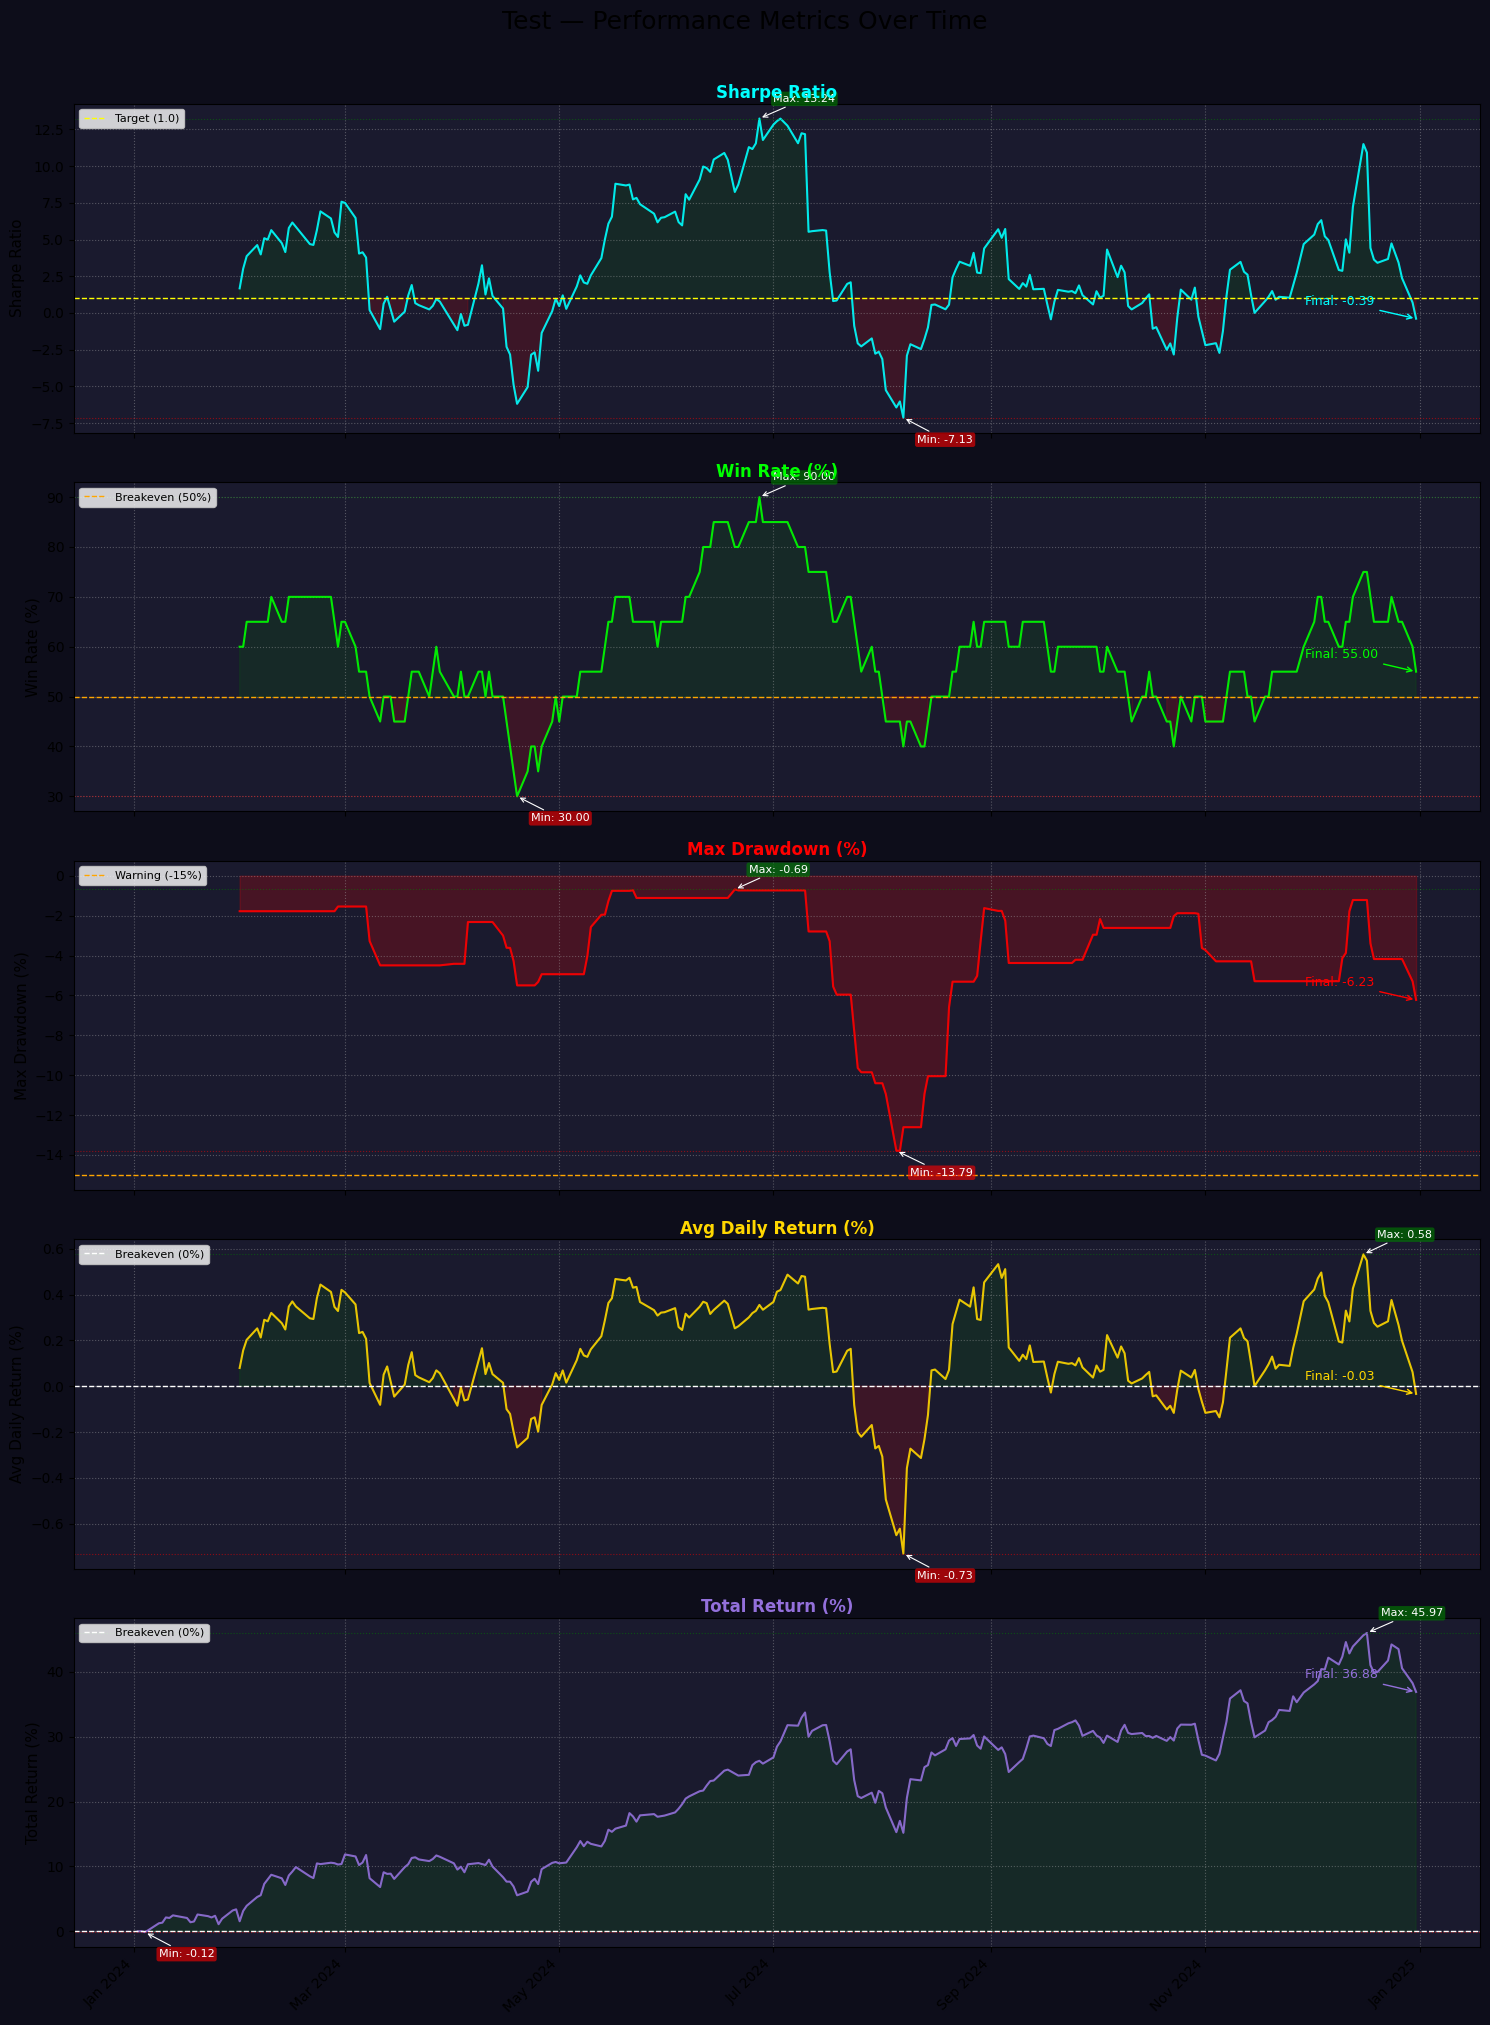


  TEST — METRIC SUMMARY
  Metric                         Avg      Max      Min    Final
  ---------------------------------------------------------
  Sharpe Ratio                  2.91    13.24    -7.13    -0.39
  Win Rate (%)                 59.38    90.00    30.00    55.00
  Max Drawdown (%)             -3.79    -0.69   -13.79    -6.23
  Avg Daily Return (%)          0.15     0.58    -0.73    -0.03
  Total Return (%)             36.88    45.97    -0.12    36.88


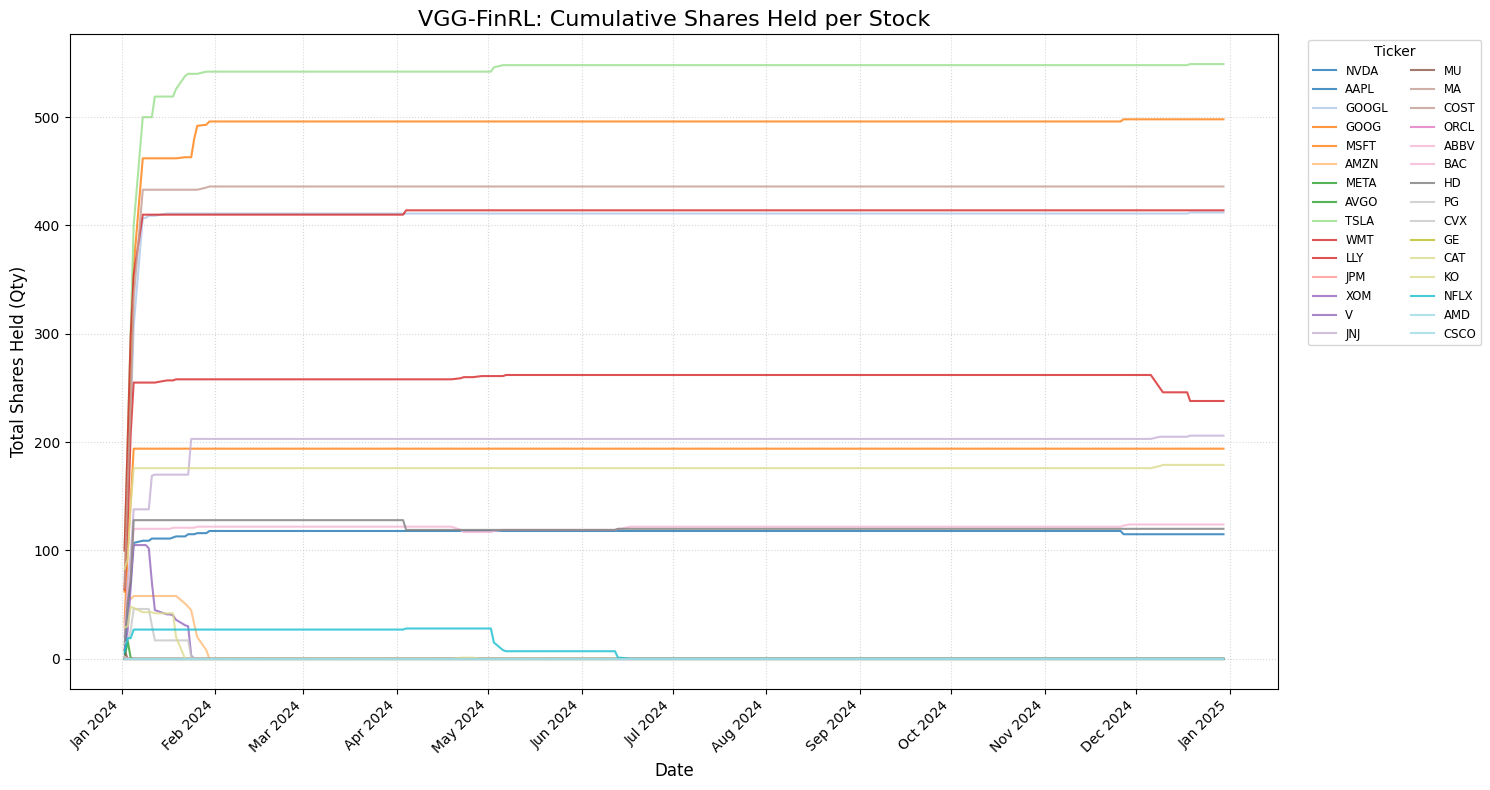

In [13]:
# ============================================================
# CELL 7 — Test Prediction & Plot
# ============================================================
print("Running prediction on test environment...")
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_vgg,
    environment=e_test_gym
)

test_metrics = compute_metrics(df_account_value)   # ← pass DataFrame directly
print(f"\n{'='*45}")
print(f"  TEST PERFORMANCE METRICS")
print(f"{'='*45}")
for metric, value in test_metrics.items():
    if isinstance(value, str):
        print(f"  {metric:<25} {value:>10}")
    else:
        print(f"  {metric:<25} {value:>10}")
print(f"{'='*45}")

# Test rolling metrics
print("\nComputing test metrics...")
test_rolling = compute_rolling_metrics(df_account_value, window=20)
plot_metrics(test_rolling, title_prefix='Test')

# ── Plot cumulative shares held ───────────────────────────────
df_shares_held = df_actions.cumsum()
dates_all      = pd.to_datetime(df_account_value['date'].values)

min_len     = min(len(dates_all), len(df_shares_held))
dates_plot  = dates_all[:min_len]
shares_plot = df_shares_held.iloc[:min_len]

fig, ax = plt.subplots(figsize=(15, 8))
colormap = plt.get_cmap('tab20', len(TICKERS))

for i, ticker in enumerate(TICKERS):
    if ticker in shares_plot.columns:
        ax.plot(dates_plot, shares_plot[ticker], label=ticker,
                color=colormap(i), linewidth=1.5, alpha=0.8)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('VGG-FinRL: Cumulative Shares Held per Stock', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Shares Held (Qty)', fontsize=12)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left',
          ncol=2, fontsize='small', title='Ticker')
ax.grid(True, linestyle=':', alpha=0.5)
fig.tight_layout()
plt.show()

hit end!


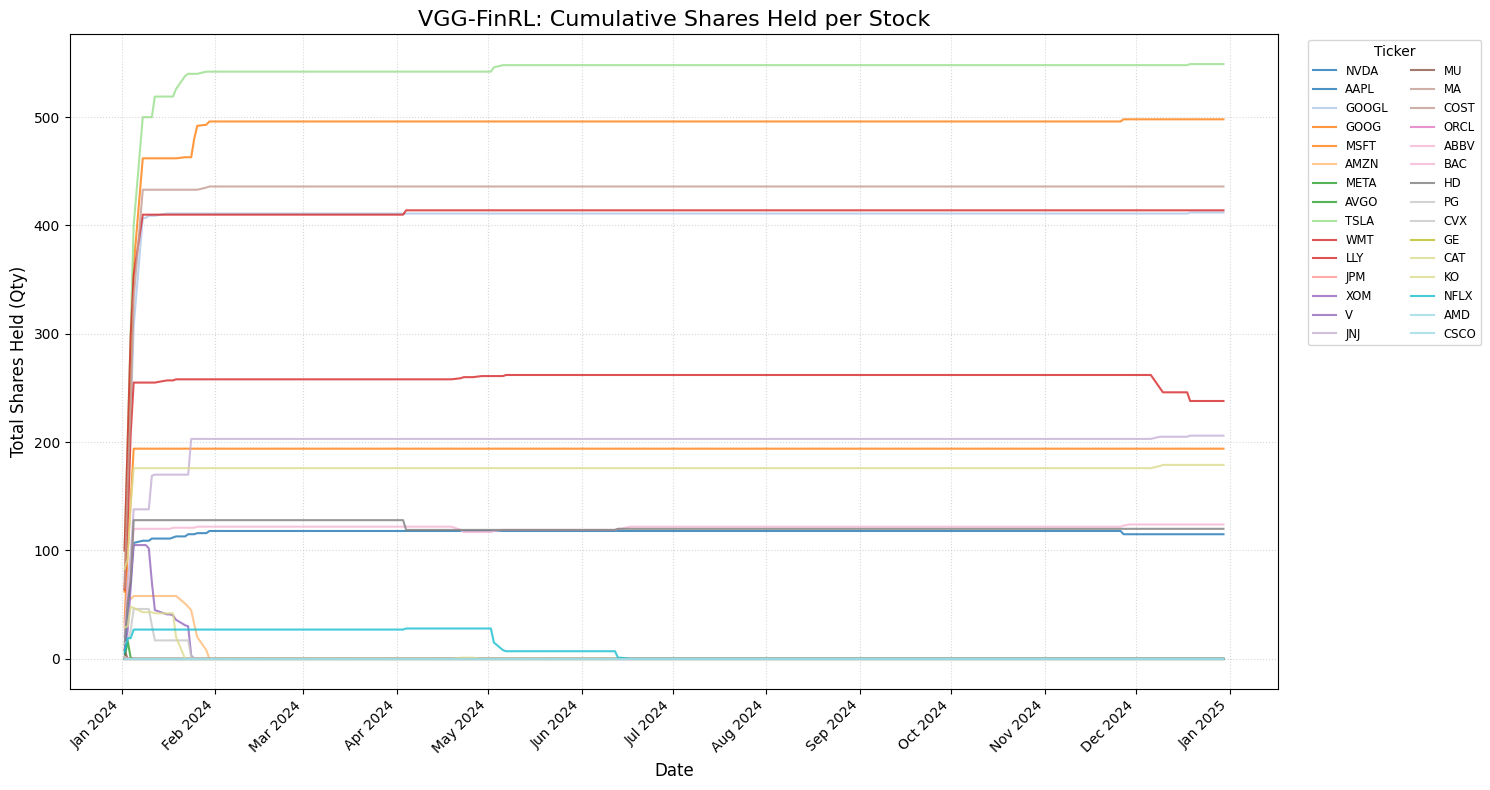

In [14]:
# ============================================================
# CELL 7 — Run Prediction & Plot Cumulative Shares Held
# ============================================================
import matplotlib.dates as mdates
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_vgg,
    environment=e_test_gym
)

# Parse dates as proper datetime
df_shares_held = df_actions.cumsum()
dates_all      = pd.to_datetime(df_account_value['date'].values)

min_len     = min(len(dates_all), len(df_shares_held))
dates_plot  = dates_all[:min_len]
shares_plot = df_shares_held.iloc[:min_len]

fig, ax = plt.subplots(figsize=(15, 8))
colormap = plt.get_cmap('tab20', len(TICKERS))

for i, ticker in enumerate(TICKERS):
    if ticker in shares_plot.columns:
        ax.plot(dates_plot, shares_plot[ticker], label=ticker,
                color=colormap(i), linewidth=1.5, alpha=0.8)

# Format x-axis as proper dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title('VGG-FinRL: Cumulative Shares Held per Stock', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Shares Held (Qty)', fontsize=12)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=2, fontsize='small', title='Ticker')
ax.grid(True, linestyle=':', alpha=0.5)
fig.tight_layout()
plt.show()


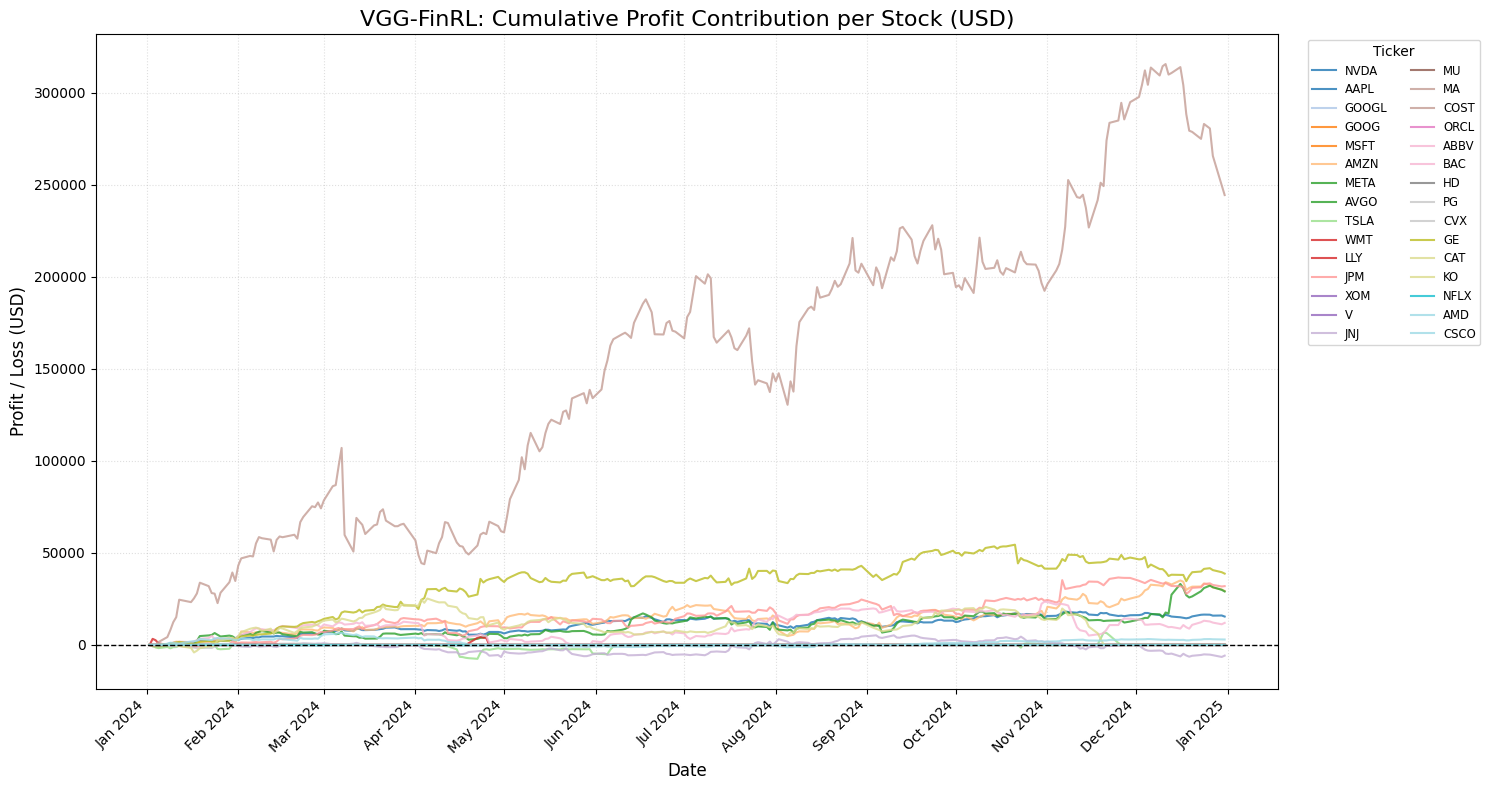

In [ ]:
# ============================================================
# CELL 8 — Plot Profit Contribution per Stock
# ============================================================
# Pivot prices and join on date index so alignment is guaranteed
df_prices_pivot = (
    e_test_gym.df
    .sort_values(['date', 'tic'])
    .pivot(index='date', columns='tic', values='close')
)

df_shares_held = df_actions.cumsum()
df_shares_held.index = dates_all[:len(df_shares_held)]  # align by date (already datetime)

# Cast price index to datetime, then reindex and forward-fill
price_dates           = pd.to_datetime(df_prices_pivot.index)
df_prices_pivot.index = price_dates
df_shares_aligned     = df_shares_held.reindex(price_dates).ffill().fillna(0)

profit_df = pd.DataFrame(index=price_dates)
for ticker in TICKERS:
    if ticker in df_prices_pivot.columns and ticker in df_shares_aligned.columns:
        prices        = df_prices_pivot[ticker]
        initial_price = prices.iloc[0]
        profit_df[ticker] = (prices - initial_price) * df_shares_aligned[ticker]

fig, ax = plt.subplots(figsize=(15, 8))
colormap = plt.get_cmap('tab20', len(TICKERS))

for i, ticker in enumerate(TICKERS):
    if ticker in profit_df.columns:
        ax.plot(profit_df.index, profit_df[ticker], label=ticker,
                color=colormap(i), linewidth=1.5, alpha=0.8)

ax.axhline(0, color='black', lw=1, linestyle='--')

# Format x-axis as proper dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title('VGG-FinRL: Cumulative Profit Contribution per Stock (USD)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Profit / Loss (USD)', fontsize=12)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=2, fontsize='small', title='Ticker')
ax.grid(True, linestyle=':', alpha=0.4)
fig.tight_layout()
plt.show()

In [ ]:
# ============================================================
# CELL 9 — Compute True P&L (Current Holding Value)
# ============================================================
true_pnl_df = (df_prices_pivot * df_shares_aligned).fillna(0)
true_pnl_df = true_pnl_df.reset_index().rename(columns={'date': 'Date'})

In [ ]:
!pip install --upgrade nbformat

In [ ]:
# ============================================================
# CELL 10 — Interactive Plotly P&L Chart
# ============================================================
final_pnl   = true_pnl_df[TICKERS].iloc[-1]
top_5       = final_pnl.nlargest(5).index.tolist()
bottom_5    = final_pnl.nsmallest(5).index.tolist()
key_tickers = set(top_5 + bottom_5)

fig = go.Figure()

for ticker in TICKERS:
    if ticker not in true_pnl_df.columns:
        continue
    fig.add_trace(go.Scatter(
        x=true_pnl_df['Date'],
        y=true_pnl_df[ticker],
        name=ticker,
        mode='lines',
        visible=True if ticker in key_tickers else 'legendonly',
        hovertemplate=f"<b>{ticker}</b><br>PnL: %{{y:$.2f}}<br>Date: %{{x}}<extra></extra>"
    ))

fig.update_layout(
    title='VGG-FinRL: Individual Stock P&L (Hover over lines to see details)',
    template='plotly_dark',
    hovermode='closest',
    hoverlabel=dict(bgcolor='black', font_size=13),
    xaxis_title='Date',
    yaxis_title='Profit / Loss (USD)',
    legend=dict(groupclick='toggleitem', traceorder='grouped')
)
fig.update_xaxes(rangeslider_visible=True)
#fig.write_html("pnl_chart.html")
#print("Open pnl_chart.html in your browser")
fig.show()

In [ ]:
# ============================================================
# CELL 11 — Future Prediction with Live NewsAPI Sentiment (Cached)
# ============================================================
from datetime import date

FUTURE_START = '2025-01-01'
FUTURE_END   = TODAY.strftime('%Y-%m-%d')

print(f"Future window: {FUTURE_START} → {FUTURE_END}")

# Download price data
df_raw_future = YahooDownloader(
    start_date=FUTURE_START,
    end_date=FUTURE_END,
    ticker_list=TICKERS
).fetch_data()

df_future_raw = fe.preprocess_data(df_raw_future)

# Fetch live sentiment — cached so re-running this cell
# won't burn extra API requests
print("Fetching live sentiment via Polygon...")
df_sent_future = build_sentiment_df_cached(
    TICKERS,
    FUTURE_START,
    FUTURE_END,
    cache_file='sentiment_future_polygon_yfinance.pkl'
)

print(f"\nLive sentiment coverage:")
print(f"  Days with at least one non-zero score: "
      f"{(df_sent_future != 0).any(axis=1).sum()} / {len(df_sent_future)}")
print(f"  Tickers with at least one score: "
      f"{(df_sent_future != 0).any(axis=0).sum()} / {len(TICKERS)}")

df_future = prepare_df(df_future_raw, df_sent_future)
print(f"\nFuture ready — {df_future['date'].nunique()} trading days")

e_future_gym = make_env(df_future)

df_future_account, df_future_actions = DRLAgent.DRL_prediction(
    model=trained_vgg,
    environment=e_future_gym
)

# ── Plot: Portfolio Value ─────────────────────────────────────
future_dates = pd.to_datetime(df_future_account['date'].values)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(future_dates, df_future_account['account_value'],
        color='cyan', linewidth=2, label='Portfolio value')
ax.axhline(1_000_000, color='white', linestyle='--',
           linewidth=1, label='Starting capital')
ax.fill_between(future_dates, 1_000_000, df_future_account['account_value'],
                where=df_future_account['account_value'] >= 1_000_000,
                alpha=0.2, color='green', label='Above baseline')
ax.fill_between(future_dates, 1_000_000, df_future_account['account_value'],
                where=df_future_account['account_value'] < 1_000_000,
                alpha=0.2, color='red', label='Below baseline')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('VGG-FinRL: Sentiment-Aware Portfolio Value (Live)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value (USD)', fontsize=12)
ax.legend(fontsize='small')
ax.grid(True, linestyle=':', alpha=0.5)
fig.tight_layout()
plt.show()

# ── Plot: Live Sentiment Heatmap ──────────────────────────────
fig, ax = plt.subplots(figsize=(15, 8))
sent_plot = df_sent_future[TICKERS].T

im = ax.imshow(sent_plot.values, aspect='auto', cmap='RdYlGn',
               vmin=-1, vmax=1, interpolation='nearest')

ax.set_yticks(range(len(TICKERS)))
ax.set_yticklabels(TICKERS, fontsize=8)

n_cols   = sent_plot.shape[1]
tick_idx = np.linspace(0, n_cols - 1, min(12, n_cols)).astype(int)
ax.set_xticks(tick_idx)
ax.set_xticklabels(
    [sent_plot.columns[i] for i in tick_idx],
    rotation=45, ha='right', fontsize=8
)

plt.colorbar(im, ax=ax, label='Sentiment Score (-1=Bearish, +1=Bullish)')
ax.set_title('Live News Sentiment Heatmap by Stock', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Ticker', fontsize=12)
fig.tight_layout()
plt.show()

# ── Interactive Plotly: Future P&L ───────────────────────────
df_future_prices = (
    e_future_gym.df
    .sort_values(['date', 'tic'])
    .pivot(index='date', columns='tic', values='close')
)

future_price_dates      = pd.to_datetime(df_future_prices.index)
df_future_prices.index  = future_price_dates
future_shares           = df_future_actions.cumsum()
future_shares_aligned   = future_shares.reindex(future_price_dates).ffill().fillna(0)

future_pnl_df = pd.DataFrame(index=future_price_dates)
for ticker in TICKERS:
    if ticker in df_future_prices.columns and ticker in future_shares_aligned.columns:
        prices        = df_future_prices[ticker]
        initial_price = prices.iloc[0]
        future_pnl_df[ticker] = (prices - initial_price) * future_shares_aligned[ticker]

future_pnl_df = future_pnl_df.reset_index().rename(columns={'date': 'Date'})

final_future_pnl = future_pnl_df[TICKERS].iloc[-1]
top_5            = final_future_pnl.nlargest(5).index.tolist()
bottom_5         = final_future_pnl.nsmallest(5).index.tolist()
key_tickers      = set(top_5 + bottom_5)

fig = go.Figure()
for ticker in TICKERS:
    if ticker not in future_pnl_df.columns:
        continue
    fig.add_trace(go.Scatter(
        x=future_pnl_df['Date'],
        y=future_pnl_df[ticker],
        name=ticker,
        mode='lines',
        visible=True if ticker in key_tickers else 'legendonly',
        hovertemplate=f"<b>{ticker}</b><br>PnL: %{{y:$.2f}}<br>Date: %{{x}}<extra></extra>"
    ))

fig.update_layout(
    title='VGG-FinRL: Sentiment-Aware Individual Stock P&L (Live)',
    template='plotly_dark',
    hovermode='closest',
    hoverlabel=dict(bgcolor='black', font_size=13),
    xaxis_title='Date',
    yaxis_title='Profit / Loss (USD)',
    legend=dict(groupclick='toggleitem', traceorder='grouped')
)
fig.update_xaxes(rangeslider_visible=True)
fig.write_html("live_sentiment_pnl.html")
print("Chart saved to live_sentiment_pnl.html")

In [ ]:
df_train.to_csv('FinRLNewsFetch_train.csv')
df_test.to_csv('FinRLNewsFetch_validation.csv')